# FAA: Práctica 1

### Autores: David Cabornero Pascual y Mario García Pascual

## 0. Introducción

La práctica 1 consiste en implementar en Python los elementos necesarios para poder manejar conjuntos de datos, estrategias de particionado y clasificadores. Después hay que probar que su funcionamiento es correcto, comparar los resultados con el de los métodos de scikit-learn, y por último ver la curva ROC de los clasificadores.

Para solucionar el problema de que la última columna de los datos German no sea categórica hemos tenido que modificar la clase Datos. La modificación consiste en añadir el argumento opcional predNominal al constructor de Datos, que en caso de ser True fuerza a la última columna a ser de tipo nominal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Clasificador import Clasificador, ClasificadorNaiveBayes
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple, ValidacionCruzada

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder

from astropy.table import QTable, Table, Column

datosGerman = Datos('german.data',predNominal=True)
datosTic = Datos('tic-tac-toe.data',predNominal=True)

cl = ClasificadorNaiveBayes()
cll = ClasificadorNaiveBayes(laplace=True)

## 1. Particionado

En esta sección comprobamos que funcionan correctamente las estrategias de particionado. Dado que la cantidad de datos es lo único que importa para realizar las particiones, probamos el funcionamiento sólo para German.

In [2]:
def showParticiones(val,datos):
    val.creaParticiones(datos)
    print('Número de particiones: ', len(val.particiones))
    for i in range(len(val.particiones)):
        print('Partición número ', i)
        print('Número de índices del trainSet:')
        print(len(val.particiones[i].indicesTrain))
        print('Número de índices del testSet:')
        print(len(val.particiones[i].indicesTest))
        print()
    # Vamos a probar a unir indicesTrain e indicesTest de una partición, ordenarlos
    # e imprimirlos, para comprobar que salen todos los indices
    print(sorted(val.particiones[0].indicesTest + val.particiones[0].indicesTrain))

El método showParticiones imprime el número de indices de Train y Test de cada partición, y después imprime el array ordenado resultante de unir las dos listas de índices.

In [3]:
propTest = 0.2 #Proporción de datos destinados al testSet
numEx = 20 # Número de ejecuciones de la validación simple
print('Particionado simple:')
valS = ValidacionSimple(0.2,10)
showParticiones(valS,datosGerman)

print('\n\n')
print('Particionado cruzado:')
numP = 6 # Número de particiones de la validación cruzada
valC = ValidacionCruzada(numP)
showParticiones(valC, datosGerman)

Particionado simple:
Número de particiones:  10
Partición número  0
Número de índices del trainSet:
800
Número de índices del testSet:
200

Partición número  1
Número de índices del trainSet:
800
Número de índices del testSet:
200

Partición número  2
Número de índices del trainSet:
800
Número de índices del testSet:
200

Partición número  3
Número de índices del trainSet:
800
Número de índices del testSet:
200

Partición número  4
Número de índices del trainSet:
800
Número de índices del testSet:
200

Partición número  5
Número de índices del trainSet:
800
Número de índices del testSet:
200

Partición número  6
Número de índices del trainSet:
800
Número de índices del testSet:
200

Partición número  7
Número de índices del trainSet:
800
Número de índices del testSet:
200

Partición número  8
Número de índices del trainSet:
800
Número de índices del testSet:
200

Partición número  9
Número de índices del trainSet:
800
Número de índices del testSet:
200

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1

German tiene 1000 datos. Hacemos la prueba de Validación Simple con una proporción de Test del 20% y 6 10 ejecuciones. Podemos ver que se imprimen 10 particiones con 800 índices de Train y 200 de Test respectivamente, y que la unión de las dos listas son todos los índices. Luego hacemos la prueba de Validación Cruzada con 6 particiones. Vemos que se imprimen 6 particiones con 834 de Train y 166 de Test, excepto la última que partición que tiene 830 y 170. 166 = floor(1000/6), y la última partición sale distinta para compensar que la división 1000/6 no sea exacta.

Validación Simple separa el conjunto de datos en train y test, entrena con los datos de train y estima el error de generalización con datos test. En su lugar, Validación Cruzada separa el conjunto de datos en K bloques, y para cada uno de los bloques, entrena con los K-1 restantes y estima el error con el bloque. Las ventajas y desventajas son:
* Validación Simple (con una ejecución) es computacionalmente menos costoso, pero a cambio desaprovecha algunos datos, que no llegan a usar para entrenar/testear en ningún momento.
* Validación Cruzada es mucho más costoso, pero sí aprovecha todos los datos y permite estimar mejor el error de generalización tomando la media de los errores de cada partición

Cuando añadimos varias ejecuciones a Validación Simple la diferencia entre ambos tipos de validación se reduce. Pongamos un ejemplo: val. simple con 20% de test y 5 ejecuciones y val. cruzada con 5 bloques. En ambos casos se obtendrían 5 particiones con aprox. 20% de test cada una. La diferencia es que las particiones obtenidas con val. simple son totalmente independientes, mientras que las de val. cruzada tienen interdependientes, pues lo bloques básicos se mantienen. En val. cruzada cada dato se utiliza K-1 veces para entrenamiento y 1 para test; en val. simple no tiene por qué ser así.

## 2. Naive-Bayes

Para aplicar la corrección de Laplace hay que poner el atributo opcional laplace a True en el constructor del clasificador Naive-Bayes. En el código del notebook, cl = Naive-Bayes sin corrección de Laplace, cll = Naive-Bayes con corrección de Laplace.

Mostramos dos tablas para cada conjunto de datos, una para el error medio y otra para la desviación típica, con/sin Laplace y según la estrategia de particionado que se ha usado.

Para conseguir que los datos obtenidos con validación cruzada y simple sean lo más comparables posibles, hemos decidido probar

* Validación Simple con 20% de test y 5 ejecuciones,
* Validación Cruzada con 5 particiones,

de tal forma que en ambos casos se obtengan 5 particiones con 20% de test en cada una.

### 2.1 German

In [4]:
propTest = 0.2 #Proporción de datos destinados al testSet
numEx = 5 # Número de ejecuciones de la validación simple
valS = ValidacionSimple(propTest,numEx)

# Validación Simple con y sin Laplace
errSL = cll.validacion(valS,datosGerman)
errS = cl.validacion(valS,datosGerman)

numP = 5 # Número de ejecuciones de la validación cruzada
valC = ValidacionCruzada(numP)

# Validación Cruzada con y sin Laplace
errCL = cll.validacion(valC,datosGerman)
errC = cl.validacion(valC,datosGerman)

print('Tabla de medias: \n')
laplace = ['No','Sí']
simple = [np.mean(errS),np.mean(errSL)]
cruzada = [np.mean(errC),np.mean(errCL)]
t = Table([laplace,simple,cruzada],names=['Laplace','Simple','Cruzada'])
print(t)

print('\n\n Tabla de desviaciones típicas:\n')
laplace = ['No','Sí']
simple = [np.std(errS),np.std(errSL)]
cruzada = [np.std(errC),np.std(errCL)]
t = Table([laplace,simple,cruzada],names=['Laplace','Simple','Cruzada'])
print(t)

Tabla de medias: 

Laplace Simple       Cruzada      
------- ------ -------------------
     No  0.318 0.30599999999999994
     Sí  0.496               0.288


 Tabla de desviaciones típicas:

Laplace        Simple             Cruzada       
------- ------------------- --------------------
     No  0.0988230742286436 0.059110066824526596
     Sí 0.05370288632839024  0.03501428280002318


### 2.2 Tic Tac Toe

In [5]:
propTest = 0.2 #Proporción de datos destinados al testSet
numEx = 5 # Número de ejecuciones de la validación simple
valS = ValidacionSimple(propTest,numEx)

# Validación Simple con y sin Laplace
errSL = cll.validacion(valS,datosTic)
errS = cl.validacion(valS,datosTic)

numP = 5 # Número de particiones de la validación cruzada
valC = ValidacionCruzada(numP)

# Validación Cruzada con y sin Laplace
errCL = cll.validacion(valC,datosTic)
errC = cl.validacion(valC,datosTic)

print('Tabla de medias: \n')
laplace = ['No','Sí']
simple = [np.mean(errS),np.mean(errSL)]
cruzada = [np.mean(errC),np.mean(errCL)]
t = Table([laplace,simple,cruzada],names=['Laplace','Simple','Cruzada'])
print(t)

print('\n\nTabla de desviaciones típicas:\n')
laplace = ['No','Sí']
simple = [np.std(errS),np.std(errSL)]
cruzada = [np.std(errC),np.std(errCL)]
t = Table([laplace,simple,cruzada],names=['Laplace','Simple','Cruzada'])
print(t)

Tabla de medias: 

Laplace        Simple            Cruzada      
------- ------------------- ------------------
     No 0.28272251308900526 0.3025638257677984
     Sí  0.3225130890052356 0.3026124035191882


Tabla de desviaciones típicas:

Laplace        Simple              Cruzada       
------- -------------------- --------------------
     No 0.037316292526084725 0.033593939809924395
     Sí 0.024467688891199834 0.020241694081128248


## 3. Scikit-learn
### 3. 1 German 


En la base de datos German aplicaremos el algoritmo de Naive-Bayes continuo, es decir, GaussianNB. Mientras que en tic-tac-toe todos los atributos son discretos, aquí sí que existen atributos continuos. Aunque Scikit-learn nos da herramientas para hacer validación cruzada, no existe un algoritmo para realizar más de una ejecución de validación simple. No será un gran problema, pero tenemos que ir haciendo manualmente cada una de las iteraciones.

No aplicaremos Lagrange, ya que solo se aplica al caso discreto. Aunque aquí podemos observar que sale algo mejor la tasa de error respecto a nuestro algoritmo, debemos tener en cuenta que aquí sí que existen diferencias sustanciales. Aquí estamos aplicando la versión continua de Naive-Bayes a los atributos continuos y a los discretos y al parecer esto beneficia al algoritmo. De todas formas, queremos recalar que esto ocurre en este dataset en concreto, y en general es mejor usar el algoritmo correspondiente al tipo de atributo.

In [6]:
propTest = 0.2 #Proporción de datos destinados al testSet
numEx = 5 # Número de ejecuciones de la validación simple
# Necesitamos separar atributos de la clasificación
X, y = datosGerman.datos[:,:-1], datosGerman.datos[:,-1].astype('int')
mult = GaussianNB()
errS = []
for _ in range(numEx):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=propTest)
    mult.fit(X_train,y_train)
    err = 1 - mult.score(X_test,y_test)
    errS.append(err)

meanS, stdS = np.mean(errS), np.std(errS)


numP = 5 # Número de particiones de la validación cruzada

# Validación Cruzada
errC = 1 - cross_val_score(mult,X,y,cv=numP)
meanC, stdC = np.mean(errC), np.std(errC)

print('Tabla de medias y desviaciones típicas de los errores: \n')
param = ['Media','D. Típica']
simple = [meanS,stdS]
cruzada = [meanC,stdC]
t = Table([param,simple,cruzada],names=['Parámetro','Simple','Cruzada'])
print(t)

Tabla de medias y desviaciones típicas de los errores: 

Parámetro        Simple              Cruzada      
--------- -------------------- -------------------
    Media                0.248               0.268
D. Típica 0.019899748742132416 0.03264965543462904


### 3. 2 Tic Tac Toe 

Para el algoritmo Tic-Tac-Toe, todos los atributos son discretos. Por ello, aplicarmos el algoritmo de Scikit-Learn discreto, es decir, MultinomialNB. Mostraremos los resultados con y sin Lagrange (cuando no se aplica Lagrange ponemos un número muy cercano a 0, pero no 0 para evitar errores numéricos).

También utilizaremos el algoritmo OneHotEncoder, que codifica los atributos discretos y ayuda a la hora de mejorar la eficiencia del programa. Sin embargo, en este caso Naive-Bayes no tiene en cuenta la diferencia entre los números que sirven de codificación. Por ello, no tiene sentido que este algoritmo mejore el error.

Como vemos, la tasa de errores es parecida, aunque algo más constante en la version de Scikit-Learn.

In [7]:
propTest = 0.2 #Proporción de datos destinados al testSet
numEx = 5 # Número de ejecuciones de la validación simple
# Necesitamos separar atributos de la clasificación
X, y = datosTic.datos[:,:-1], datosTic.datos[:,-1].astype('int')
#OneHotEncoder
enc = OneHotEncoder()
X_new = enc.fit_transform(X)

multL = MultinomialNB() # Naive-Bayes con Lagrange
mult = MultinomialNB(alpha=1.0e-10) #Naive-Bayes sin Lagrange, se aproxima a cero para evitar errores numéricos

#Validación simple con Lagrange
errSL = []
for _ in range(numEx):
    X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=propTest)
    multL.fit(X_train,y_train)
    err = 1 - multL.score(X_test,y_test)
    errSL.append(err)

meanSL, stdSL = np.mean(errSL), np.std(errSL)

#Validación simple sin Lagrange
errS = []
for _ in range(numEx):
    X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=propTest)
    mult.fit(X_train,y_train)
    err = 1 - mult.score(X_test,y_test)
    errS.append(err)

meanS, stdS = np.mean(errS), np.std(errS)

numP = 5 # Número de particiones de la validación cruzada

# Validación Cruzada con Lagrange
errCL = 1 - cross_val_score(multL,X_new,y,cv=numP)
meanCL, stdCL = np.mean(errCL), np.std(errCL)

# Validación Cruzada sin Lagrange
errC = 1 - cross_val_score(mult,X_new,y,cv=numEx)
meanC, stdC = np.mean(errC), np.std(errC)

#Tablas
print('Tabla de medias: \n')
laplace = ['No','Sí']
simple = [meanS,meanSL]
cruzada = [meanC,meanCL]
t = Table([laplace,simple,cruzada],names=['Laplace','Simple','Cruzada'])
print(t)

print('\n\nTabla de desviaciones típicas:\n')
laplace = ['No','Sí']
simple = [stdS,stdSL]
cruzada = [stdC,stdCL]
t = Table([laplace,simple,cruzada],names=['Laplace','Simple','Cruzada'])
print(t)

Tabla de medias: 

Laplace        Simple            Cruzada      
------- ------------------- ------------------
     No  0.2958333333333333 0.3371727748691099
     Sí 0.29791666666666666 0.3371727748691099


Tabla de desviaciones típicas:

Laplace        Simple              Cruzada      
------- -------------------- -------------------
     No 0.015590239111558104 0.05794563417312506
     Sí 0.014129854131510996 0.05794563417312506


## 4. Evaluación de hipótesis mediante análisis ROC

Para construir la matriz de confusión hemos implementado el método get_confusion_matrix(datos,proporcionTest) para la clase Clasificador, que devuelve la matriz de confusión del clasificador utilizando validación simple con la proporción de test dada. Una vez tenemos la matriz de confusión, la función show_roc_curve obtiene la tasa de verdaderos positivos y la tasa de falsos positivos y las grafica en el espacio ROC uniendo dicho punto con el (0,0) y (1,1).

In [8]:
def show_roc_curve(conf_mat):
    err = (conf_mat[0,1] + conf_mat[1,0])/np.sum(conf_mat)
    print(conf_mat)
    print("Tasa de error: ",err)
    tpr = conf_mat[0,0] / np.sum(conf_mat[0])
    fpr = conf_mat[1,0] / np.sum(conf_mat[1])
    print("Tasa de verdaderos positivos (TPR): ",tpr)
    print("Tasa de falsos positivos (FPR): ", fpr)
    x = [0, fpr, 1]
    y = [0, tpr, 1]
    plt.plot(x,y)
    plt.show()

Curva ROC de tic-tac-toe
[[156.  30.]
 [ 68.  33.]]
Tasa de error:  0.34146341463414637
Tasa de verdaderos positivos (TPR):  0.8387096774193549
Tasa de falsos positivos (FPR):  0.6732673267326733


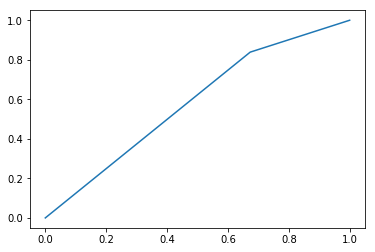

Curva ROC de german
[[ 63.  20.]
 [120.  97.]]
Tasa de error:  0.4666666666666667
Tasa de verdaderos positivos (TPR):  0.7590361445783133
Tasa de falsos positivos (FPR):  0.5529953917050692


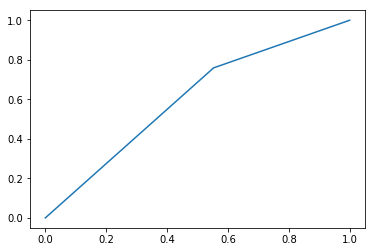

In [11]:
# Muestra la curva ROC de tic-tac-toe
datosGerman = Datos("german.data",predNominal=True)
cll = ClasificadorNaiveBayes(laplace=True)
print("Curva ROC de tic-tac-toe")
conf_mat = cll.get_confusion_matrix(datosTic,proporcionTest=0.3)
show_roc_curve(conf_mat)
# Muestra la curva ROC de german
print("Curva ROC de german")
conf_mat = cll.get_confusion_matrix(datosGerman,proporcionTest=0.3)
show_roc_curve(conf_mat)

Al utilizar validación simple con una sola ejecución las curvas ROC pueden cambiar sustancialmente entre ejecución y ejecución.